In [1]:
using Revise
includet("paper.jl")

using Gnuplot
import Base.show
#show(io::IO, ::MIME"text/html", gp::Gnuplot.GPSession) = Gnuplot._show(io, gp, "svg enhanced standalone mouse size 400,250")
show(io::IO, ::MIME"text/html", gp::Gnuplot.GPSession) = Gnuplot._show(io, gp, "svg enhanced standalone mouse size 800,800")
using DataFrames, DataFramesMeta, CSV
using JLD2
using DelimitedFiles

## Model Descriptions
The output of `modelresults` includes the Bayesian inference of all the parameters of the model specifically the posterior distributions of :ρ, β, and θ. The output also includes the posterior predictive checks.

### Limitation

When inferring the parameters of rho, beta, and theta, the model uses all data (both unvaccinated and vaccinated matrices). This means that rho and beta are "contaminated" and include the effect of vaccine in the inference. However, we tested this effect two ways: We trained rho and beta using only the first 4 data points (i.e., set `max_t = 4` in the `model` function). This slightly changed the values of rho and beta (but did not change the overall parameter λ since it's the combination of rho and beta). This is "flawed" in the sense that if we were to fix these numbers (i.e. keep them constants) for post-vaccination, then why do we need to train theta, only to turn it off and return back to the constant values. 

In a second test, we set `max_d = 1`. This means we are inferring the values of rho and beta using the unvaccinated data only. This result produced almost exact results as if we included the vaccinated data. This implies the effect of direct vaccine is mostly captured by theta. It is true that rho/beta are also being adjusted but this adjustment is very very minor as shown by the test (and in fact, we can not differentiate whether the effect is due to vaccine data or just stochasticity)

One important note is the effect of indirect dynamics. We see in the "non vaccinated" data that there is a declining trend. This declining trend is likely due to vaccine (i.e. herd immunity) so it's impossible to figure out exactly what the direct effect is.

### Adding a new parameter for the variance of the beta parameter

We added σ as a parameter for each of the beta distributions. We did this because hard coding the variance was not ideal. We wanted to infer the variance of the beta parameter as well. We then tested that picking different priors for sigma reached the same posterior/results and indeed it did.

In [2]:
savefile = "./output/model_output" # don't append file type (done in the save command)
savefile_tp = "./output/posterior_distributions" 
maxiter = 40000
modelresults, data, popsize = run_model(;iter=maxiter, ag45=false)
max_ag, max_t, max_d = size(data) # maximum age group, time, vaccine 
println("dimensions: max_ag: $max_ag, max_t: $max_t, max_d: $max_d")
modelresults

running model - params: iter: 40000, ag45: false


┌ Info: Found initial step size
│   ϵ = 0.00078125
└ @ Turing.Inference /home/affans/.julia/packages/Turing/lkUBK/src/mcmc/hmc.jl:191


dimensions: max_ag: 8, max_t: 21, max_d: 3


Chains MCMC chain (40000×64×1 Array{Float64, 3}):

Iterations        = 1001:1:41000
Number of chains  = 1
Samples per chain = 40000
Wall duration     = 1231.79 seconds
Compute duration  = 1231.79 seconds
parameters        = ρ[1], ρ[2], ρ[3], ρ[4], ρ[5], ρ[6], ρ[7], ρ[8], b[1], b[2], b[3], b[4], b[5], b[6], b[7], b[8], b[9], b[10], b[11], b[12], b[13], b[14], b[15], b[16], b[17], b[18], b[19], b[20], b[21], σ[1], σ[2], σ[3], σ[4], σ[5], σ[6], σ[7], σ[8], σ[9], σ[10], σ[11], σ[12], σ[13], σ[14], σ[15], σ[16], σ[17], σ[18], σ[19], σ[20], σ[21], θ₁, θ₂
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters       mean       std      mcse    ess_bulk    ess_tail      rhat  ⋯
      Symbol    Float64   Float64   Float64     Float64     Float64   Float64  ⋯

        ρ[1]    -9.3984    0.1879    0.0044   1830.3206   

In [3]:
function theta_analysis(modelresults, data, popsize, partialtheta) 
    # we need to turn thetha off to turn off the vaccine effects
    # have to get to the internals of the model to turn off thetha 
    rho, rhoquants = describe(group(modelresults, :ρ)) 
    beta, betaquants = describe(group(modelresults, :b))
    theta1, theta1quants = describe(group(modelresults, :θ₁)) 
    theta2, theta2quants = describe(group(modelresults, :θ₂)) 

    # means and quantiles of the posterior of all parameters
    rmeans = rho.nt.mean
    rupper = rhoquants.nt.var"97.5%"
    rlower = rhoquants.nt.var"2.5%"

    bmeans = beta.nt.mean
    bupper = betaquants.nt.var"97.5%"
    blower = betaquants.nt.var"2.5%"

    t1means = theta1.nt.mean
    t1upper = theta1quants.nt.var"97.5%"
    t1lower = theta1quants.nt.var"2.5%"

    t2means = theta2.nt.mean
    t2upper = theta2quants.nt.var"97.5%"
    t2lower = theta2quants.nt.var"2.5%"

    # get dimensionality of the data
    max_ag, max_t, max_d = size(data)

    # create empty matrices to store the results 
    # this creates a d-dimensional dataset (d comes from data) 
    # poster is the matrix that stores the result when theta is turned off! poster_thetaon is the fit to the model with theta on
    # the poster[:, :, 1] is for the case when d == 1 (i.e, infected individuals with no vaccine)
    # the poster[:, :, 2] is for the case when d == 2 (i.e., infected individuals with vaccine first dose)
    # the poster[:, :, 3] is for the case when d == 3 (i.e., infected individuals with vaccine second dose)
    poster = similar(data, Float64)
    poster_upper = similar(data, Float64)
    poster_lower = similar(data, Float64)

    poster_thetaon = similar(data, Float64)
    poster_upper_thetaon = similar(data, Float64)
    poster_lower_thetaon = similar(data, Float64)

    # loop through the dimensions and fill out poster/poster_thetaon 
    for d = 1:max_d
        for t = 1:max_t
            for ag = 1:max_ag
                if d == 1 # no vaccine 
                    λ = log(popsize[ag, t, d]) + rmeans[ag] + bmeans[t] 
                    λᵤ = log(popsize[ag, t, d]) + rupper[ag] + bupper[t]
                    λₗ = log(popsize[ag, t, d]) + rlower[ag] + blower[t]
                    
                    poster[ag, t, d] = mean(Poisson(exp(λ)))
                    poster_upper[ag, t, d] = mean(Poisson(exp(λᵤ)))
                    poster_lower[ag, t, d] = mean(Poisson(exp(λₗ)))
    
                    # since theta = 0 by definition when d == 1, we can just use the same values as above
                    # both poster and poster_thetaon would have the same values
                    poster_thetaon[ag, t, d] = mean(Poisson(exp(λ)))
                    poster_upper_thetaon[ag, t, d] = mean(Poisson(exp(λᵤ)))
                    poster_lower_thetaon[ag, t, d] = mean(Poisson(exp(λₗ)))
                    
                else # d = 2, 3 (i.e., the effect of vaccine is in theta)
                    if popsize[ag, t, d] > 0 # only do the analysis if there was even any vaccine coverage otherwise number of infections is 0 (i.e., 0 infections out of vaccinated population)

                        # depending on whether d == 2 (i.e., first dose) or d == 3 (i.e., second dose) 
                        # pick the correct theta value (for this specific for loop combination) 
                        _tmean = d == 2 ? t1means[1] : t2means[1]
                        _tupper = d == 2 ? t1upper[1] : t2upper[1]
                        _tlower = d == 2 ? t1lower[1] : t2lower[1]

                        λ = log(popsize[ag, t, d]) + rmeans[ag] + bmeans[t] + _tmean 
                        λᵤ = log(popsize[ag, t, d]) + rupper[ag] + bupper[t] + _tupper 
                        λₗ = log(popsize[ag, t, d]) + rlower[ag] + blower[t] + _tlower
                        poster_thetaon[ag, t, d] = mean(Poisson(exp(λ)))
                        poster_upper_thetaon[ag, t, d] = mean(Poisson(exp(λᵤ)))
                        poster_lower_thetaon[ag, t, d] = mean(Poisson(exp(λₗ)))

                        # turn theta off (both or theta2)
                        if partialtheta
                            _tmean = d == 2 ? t1means[1] : 0  
                            _tupper = d == 2 ? t1upper[1] : 0 
                            _tlower = d == 2 ? t1lower[1] : 0 
                        else  
                            _tmean = 0
                            _tupper = 0
                            _tlower = 0    
                        end 
                        λ = log(popsize[ag, t, d]) + rmeans[ag] + bmeans[t]  + _tmean 
                        λᵤ = log(popsize[ag, t, d]) + rupper[ag] + bupper[t] + _tupper 
                        λₗ = log(popsize[ag, t, d]) + rlower[ag] + blower[t]  + _tlower 
                        poster[ag, t, d] = mean(Poisson(exp(λ)))
                        poster_upper[ag, t, d] = mean(Poisson(exp(λᵤ)))
                        poster_lower[ag, t, d] = mean(Poisson(exp(λₗ)))
                    else # there is no vaccinated population so number of infections in this group == 0 
                        poster[ag, t, d] = mean(Poisson(0))
                        poster_upper[ag, t, d] = mean(Poisson(0))
                        poster_lower[ag, t, d] = mean(Poisson(0))
    
                        poster_thetaon[ag, t, d] = mean(Poisson(0))
                        poster_upper_thetaon[ag, t, d] = mean(Poisson(0))
                        poster_lower_thetaon[ag, t, d] = mean(Poisson(0))
                    end 
                end # ag
            end # t
        end # d
    end
    # add all the infections among subgroups (i.e., over the vaccine status, i.e., d)
    total_mean_manual = dropdims(sum(poster, dims=3);dims=3)
    total_mean_upper = dropdims(sum(poster_upper, dims=3);dims=3)
    total_mean_lower = dropdims(sum(poster_lower, dims=3);dims=3)

    total_mean_thetaon = dropdims(sum(poster_thetaon, dims=3);dims=3)
    total_mean_upper_thetaon = dropdims(sum(poster_upper_thetaon, dims=3);dims=3)
    total_mean_lower_thetaon = dropdims(sum(poster_lower_thetaon, dims=3);dims=3)

    return total_mean_manual, total_mean_upper, total_mean_lower, total_mean_thetaon, total_mean_upper_thetaon, total_mean_lower_thetaon
end

# helper function
gpp(p) = reshape(p, (max_t * max_ag)) 

gpp (generic function with 1 method)

partial theta: false
mean difference ag4: 172.0, range: 85.0 - 345.0
mean difference ag5: 328.0, range: 164.0 - 646.0
total in both agegroups: 500.0 
deaths prevented: 16.0 range: 8.0 - 31.0
deaths prevented: 38.0 range: 19.0 - 75.0

partial theta: true
mean difference ag4: 0.0, range: 0.0 - 0.0
mean difference ag5: 85.0, range: 43.0 - 160.0
total in both agegroups: 85.0 
deaths prevented: 0.0 range: 0.0 - 0.0
deaths prevented: 10.0 range: 5.0 - 19.0



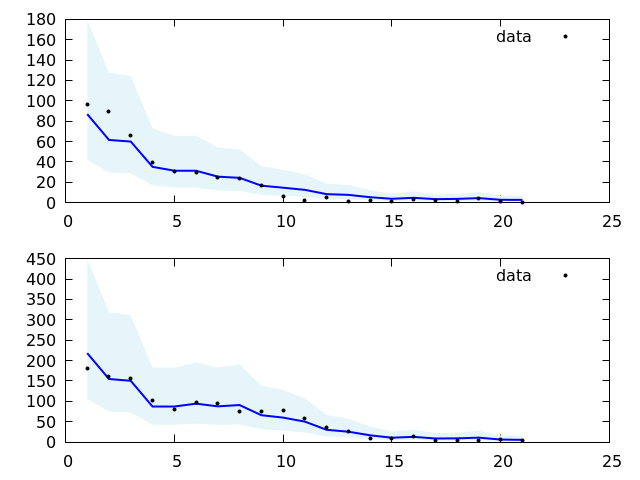

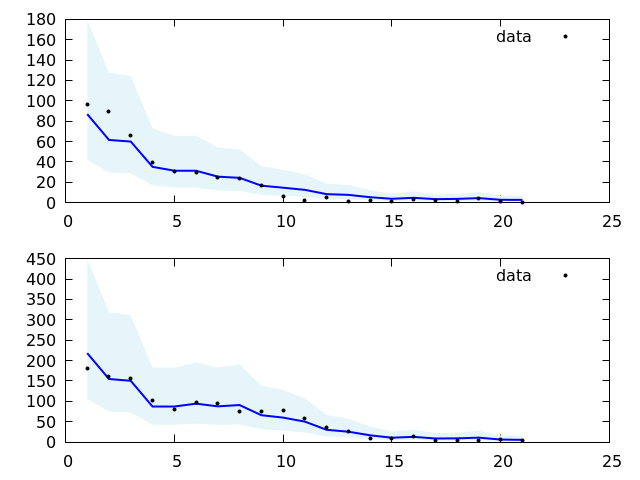

In [4]:
# save the data with both theta off (and partial theta off)
# EDIT: MAY 5, 2021: We don't actually use the partial theta off analysis in the paper
#       We don't have the data for it
for partval in [false, true]
    total_mean_manual, total_mean_upper, total_mean_lower, 
    total_mean_thetaon, total_mean_upper_thetaon, total_mean_lower_thetaon = theta_analysis(modelresults, data, popsize, partval)
    
    println("partial theta: $partval")

    @gp "reset" 
    @gp :- "set multiplot layout 2,1 "

    # plot the bayesian model results 
    # for i = 4:5
    #     @gp :- (i-3) 1:max_t total_mean_lower[i, :] total_mean_upper[i, :] "with filledcu notitle lc rgb '#e5f5f9'"
    # end

    # for i = 4:5
    #     @gp :- (i-3) 1:max_t total_mean_manual[i, :] "with lines notitle lw 2 lc 'red'" :-
    # end

    for i = 4:5
        @gp :- (i-3) 1:max_t total_mean_lower_thetaon[i, :] total_mean_upper_thetaon[i, :] "with filledcu notitle lc rgb '#e5f5f9'"
    end

    for i = 4:5
        @gp :- (i-3) 1:max_t total_mean_thetaon[i, :] "with lines notitle lw 2 lc 'blue'" :-
    end
    # plot the data
    for i = 4:5
        @gp :- (i-3) 1:max_t (data[i, :, 1] + data[i, :, 2]) "with points title 'data' pointtype 7 pointsize 0.5 lc 'black'" :-
    end
    display(@gp)

    mean_diff_ag4 = round(sum(abs.(total_mean_manual[4, :] - total_mean_thetaon[4, :])))
    mean_diff_ag5 = round(sum(abs.(total_mean_manual[5, :] - total_mean_thetaon[5, :])))
    lower_diff_ag4 = round(sum(abs.(total_mean_lower[4, :] - total_mean_lower_thetaon[4, :])))
    lower_diff_ag5 = round(sum(abs.(total_mean_lower[5, :] - total_mean_lower_thetaon[5, :])))
    upper_diff_ag4 = round(sum(abs.(total_mean_upper[4, :] - total_mean_upper_thetaon[4, :])))
    upper_diff_ag5 = round(sum(abs.(total_mean_upper[5, :] - total_mean_upper_thetaon[5, :])))

    # if ag45 = true, then ag4 and ag5 are combined so just look at the first println
    println("mean difference ag4: $mean_diff_ag4, range: $lower_diff_ag4 - $upper_diff_ag4")
    println("mean difference ag5: $mean_diff_ag5, range: $lower_diff_ag5 - $upper_diff_ag5")
    println("total in both agegroups: $(mean_diff_ag4 + mean_diff_ag5) ")

    cfr_rate_ag4 = 0.091 
    cfr_rate_ag5 = 0.116 
    println("deaths prevented: $(round(mean_diff_ag4 * cfr_rate_ag4)) range: $(round(lower_diff_ag4 * cfr_rate_ag4)) - $(round(upper_diff_ag4 * cfr_rate_ag4))")
    println("deaths prevented: $(round(mean_diff_ag5 * cfr_rate_ag5)) range: $(round(lower_diff_ag5 * cfr_rate_ag5)) - $(round(upper_diff_ag5 * cfr_rate_ag5))")
   
    # create a dataframe to plot the results / send to colleagues
    _thethaoff_df = DataFrame(idx = 1:(max_t * max_ag),
                            mean_thetaon = gpp(total_mean_thetaon),
                            lower_thetaon = gpp(total_mean_lower_thetaon),
                            upper_thetaon = gpp(total_mean_upper_thetaon),
                            mean_thetaoff = gpp(total_mean_manual),
                            lower_thetaoff = gpp(total_mean_lower), 
                            upper_thetaoff = gpp(total_mean_upper))

    _savefile = partval ? savefile * "_partial" : savefile # adjust the filename
    CSV.write("$_savefile.csv", _thethaoff_df)
    _thethaoff_df
    println("")
end

In [5]:
# plot/save the trace plots 
val = get(modelresults, [:ρ, :b, :θ₁, :θ₂, :σ])

# create a dataframe to save the results 
mf_df = DataFrame(modelresults)
#vscodedisplay(mf_df)
nonused_colnames = Symbol.(["iteration", "chain", "lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"])
select!(mf_df, Not(nonused_colnames));
CSV.write("$savefile_tp.csv", mf_df)

# print out the credible intervals as vscodedisplay to make copy/paste easier
strvals = Vector{String}(undef, length(val.ρ))
for (i, p) in enumerate(val.ρ)
    mval = round(mean(p.data), digits = 3)
    qval = round.(quantile(p.data, [0.025, 0.975]), digits=3)
    strvals[i] = "$mval ($(qval[1]), $(qval[2]))"
end
vscodedisplay(DataFrame(p = strvals))

strvals = Vector{String}(undef, length(val.b))
for (i, p) in enumerate(val.b)
    mval = round(mean(p.data), digits = 3)
    qval = round.(quantile(p.data, [0.025, 0.975]), digits=3)
    strvals[i] = "$mval ($(qval[1]), $(qval[2]))"
end
vscodedisplay(DataFrame(b = strvals))

strvals = Vector{String}(undef, length(val.σ))
for (i, p) in enumerate(val.σ)
    mval = round(mean(p.data), digits = 3)
    qval = round.(quantile(p.data, [0.025, 0.975]), digits=3)
    strvals[i] = "$mval ($(qval[1]), $(qval[2]))"
end
vscodedisplay(DataFrame(s = strvals))

#vscodedisplay(DataFrame(s = strvals))
display("theta1  $(mean(val.θ₁))  quantile: $(quantile(val.θ₁, [0.025, 0.975]))")
display("theta2  $(mean(val.θ₂))  quantile: $(quantile(val.θ₂, [0.025, 0.975]))")


"theta1  -1.9109427988975896  quantile: [-2.1501805303260504, -1.685076634867609]"

"theta2  -1.8061124678091325  quantile: [-2.3114068030718773, -1.3520904725522627]"

In [78]:
# similar to above but sample from the distributions 
# write the code to get the results 
# FUNCTION IS OUTDATED AFTER ADDING THE SIGMA PART IN
function sample_curves() 
    val = get(modelresults, [:ρ, :b, :θ])   
    # this function returns one single realization 
    poster = similar(data, Float64)
    poster_thetaon = similar(data, Float64)
    for d = 1:max_d
        for t = 1:max_t
            for ag = 1:max_ag
                # sample the numbers 
                rsamp = rand(val.ρ[ag].data)
                bsamp = rand(val.b[t].data)
                tsamp = rand(val.θ.data)
                if d == 1 # no vaccine 
                    λ = log(popsize[ag, t, d]) + rsamp + bsamp
                    poster[ag, t, d] = mean(Poisson(exp(λ)))
                    poster_thetaon[ag, t, d] = mean(Poisson(exp(λ))) # since theta = 0 by definition

                else 
                    if popsize[ag, t, d] > 0 
                        λ = log(popsize[ag, t, d]) + rsamp + bsamp #+ tmeans[1]
                        poster[ag, t, d] = mean(Poisson(exp(λ)))
                        
                        λ = log(popsize[ag, t, d]) + rsamp + bsamp + tsamp
                        poster_thetaon[ag, t, d] = mean(Poisson(exp(λ)))
                    else 
                        poster[ag, t, d] = mean(Poisson(0))
                        poster_thetaon[ag, t, d] = mean(Poisson(0))
                    end 
                end
            end
        end
    end
    # sum the infections (due to no vaccine subgroup and vaccine subgroup together) 
    total_inf_thetaoff = dropdims(sum(poster, dims=3);dims=3)
    total_inf_thetaon = dropdims(sum(poster_thetaon, dims=3);dims=3)

    return total_inf_thetaoff, total_inf_thetaon
end
total_inf_thetaoff, total_inf_thetaon = sample_curves()
show(io::IO, ::MIME"text/html", gp::Gnuplot.GPSession) = Gnuplot._show(io, gp, "svg enhanced standalone mouse size 800,800")
@gp "reset" 
@gp :- "set multiplot layout 4,2 "
for i = 1:max_ag
    @gp :- i 1:max_t total_inf_thetaoff[i, :] "with lines notitle lw 2 lc 'red'" :-
end

for i = 1:max_ag
    @gp :- i 1:max_t total_inf_thetaon[i, :] "with lines notitle lw 2 lc 'blue'" :-
end
# plot the data
for i = 1:max_ag
    @gp :- i 1:max_t (data[i, :, 1] + data[i, :, 2]) "with lines notitle lw 2 lc 'black'" :-
end
display(@gp)


# use the above function to sample 1000 curves 
nsims = 1000
curves_thetaon = zeros(Float64, max_ag*max_t, nsims)
curves_thetaoff = zeros(Float64, max_ag*max_t, nsims)
for i = 1:nsims 
    _total_inf_thetaoff, _total_inf_thetaon = sample_curves()
    total_inf_thetaoff = vec(_total_inf_thetaoff)
    total_inf_thetaon = vec(_total_inf_thetaon)
    curves_thetaoff[:, i] .= total_inf_thetaoff
    curves_thetaon[:, i] .= total_inf_thetaon
end
#writedlm("./output/sampled_curves_thetaoff.csv", curves_thetaoff, ',')
#writedlm("./output/sampled_curves_thetaon.csv", curves_thetaon, ',')

# fix code if using consolidated age groups 4 and 5
diff = abs.(curves_thetaon .- curves_thetaoff)
ag4_idx = collect(4:8:168)
ag4_diff = diff[ag4_idx, :]
ag4_cumdiff = vec(sum(ag4_diff, dims=1))
ag4_mean = mean(ag4_cumdiff)
ag4_quants = quantile(ag4_cumdiff, [0.025, 0.975])
println("mean: $(ag4_mean), quantiles: $(ag4_quants)")

ErrorException: type NamedTuple has no field θ